In [4]:
#NBVAL_IGNORE_OUTPUT
# Adding ignore due to (probably an np notebook magic) bug
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [1]:
from devito import *

In [2]:
from examples.seismic import Model, plot_velocity

In [ ]:
import numpy as np
import pandas as pd

def capas_pre_devito(vel_original, no_capas, shape_z):
    '''
    Función para calcular la matriz de capas de entrada para hacer el campo de velocidades para devito
    La entrada vel_original debe ser un dataframe con las siguientes columnas ['DEPTH', 'ACOUSTIC_INTERVAL_VEL', 'DELTA_DEPTH']
    no_capas: Las capas que deseo para mi modelo
    Shape_z= la dimención de
    '''
    
    
    depth_max = vel_original['DEPTH'].max()
    intervalo = round(depth_max / (no_capas - 1), 2)
    
    new_depth = np.arange(0, depth_max, intervalo)
    new_df = pd.DataFrame({'DEPTH': new_depth})
    
    # Interpolación de los valores de velocidad acústica
    new_df['ACOUSTIC_INTERVAL_VEL'] = np.interp(new_df['DEPTH'], vel_original['DEPTH'], vel_original['ACOUSTIC_INTERVAL_VEL'])
    
    # Cálculo de CAPA_INFERIOR
    new_df['CAPA_INFERIOR'] = new_df['DEPTH'] + intervalo / 2
    new_df.iloc[-1, new_df.columns.get_loc('CAPA_INFERIOR')] = new_df['DEPTH'].iloc[-1]
    
    # Cálculo de FILA_INF
    new_df['FILA_INF'] = np.round(new_df['CAPA_INFERIOR'] * (shape_z - 1) / depth_max + 1).astype(int)
    
    # Creación de las capas con FILA_INF y ACOUSTIC_INTERVAL_VEL
    capas = list(zip(new_df['FILA_INF'], new_df['ACOUSTIC_INTERVAL_VEL'] / 1000))
    
    return capas


In [100]:
def campo_velocidades_devito(shape, capas):
    """
    Genera un campo de velocidades con un número variable de capas.

    Parameters:
    - shape: Tuple que define la forma de la matriz (número de filas, número de columnas).
    - capas: Lista de tuplas, donde cada tupla contiene dos valores:
             (profundidad_final, velocidad), siendo profundidad_final la columna final de la capa
             y velocidad la velocidad asignada a esa capa.

    Returns:
    - Vel_Devito: Matriz numpy con el campo de velocidades.
    """
    Vel_Devito = np.empty(shape, dtype=np.float32)
    
    # Inicializar el índice inicial en 0
    indice_inicial = 0
    
    for profundidad_final, velocidad in capas:
        Vel_Devito[:, indice_inicial:profundidad_final] = velocidad
        indice_inicial = profundidad_final
    
    return Vel_Devito




In [5]:
Vel_Pozo= pd.read_csv('vel_pozo_edit.csv')

In [6]:
Vel_Pozo

,DEPTH,ACOUSTIC_INTERVAL_VEL,DELTA_DEPTH
0,128.67132,2107.0824,4.78536
1,133.45668,1933.9560,4.78536
2,138.24204,1833.0672,4.78536
3,143.02740,1778.5080,4.78536
4,147.81276,1723.0344,4.78536
...,...,...,...
502,2487.03084,4012.0824,4.78536
503,2491.81620,4429.9632,4.78536
504,2496.60156,4684.4712,4.78536
505,2501.38692,4578.7056,4.78536


In [73]:
Vel_Pozo.columns

Index(['DEPTH', 'ACOUSTIC_INTERVAL_VEL', 'DELTA_DEPTH'], dtype='object')

In [90]:
depth_max=Vel_Pozo.DEPTH.max()
depth_max

np.float64(2506.17228)

In [91]:
# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
dz=depth_max/(shape[1]-1)
dz

np.float64(25.0617228)

In [92]:
dx=dz

In [93]:
# Define a physical size

spacing = (dx, dz)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

In [104]:
capas=capas_pre_devito(Vel_Pozo,10,shape[1])
capas

[(7, 2.1070824),
 (18, 2.1777239006369435),
 (29, 2.473975788535032),
 (40, 3.141375899999998),
 (51, 3.5620631839464885),
 (62, 3.304139300662255),
 (73, 3.454794050814337),
 (84, 3.006359699035368),
 (95, 3.14028474649682),
 (101, 4.427636369426749)]

In [105]:
v=v = campo_velocidades_devito(shape, capas)

Operator `initdamp` ran in 0.01 s


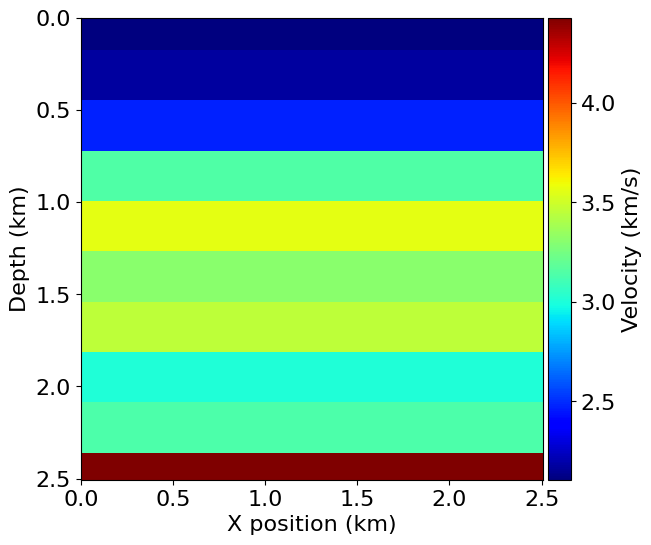

In [106]:
# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)